# AMAZON SALES ANALYSIS #

    This dataset contains over a thousand Amazon Product's Ratings and Reviews scraped from Amazon. Our goal with the data is to demonstrate data science methodologies and extract meaningful information about the most successful items on Amazon.

### Variables ###

product_id - Product ID

product_name - Name of the Product

category - Category of the Product

discounted_price - Discounted Price of the Product

actual_price - Actual Price of the Product

discount_percentage - Percentage of Discount for the Product

rating - Rating of the Product

rating_count - Number of people who voted for the Amazon rating

about_product - Description about the Product

user_id - ID of the user who wrote review for the Product

user_name - Name of the user who wrote review for the Product

review_id - ID of the user review

review_title - Short review

review_content - Long review

img_link - Image Link of the Product

product_link - Official Website Link of the Product


In [2]:
import kagglehub
path = kagglehub.dataset_download("karkavelrajaj/amazon-sales-dataset")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import os
%matplotlib inline

## Cleaning and Analyzing Initial Dataset


i) Below is an example of how the dataset is presented.

In [4]:

csv_path = os.path.join(path, "amazon.csv")
df = pd.read_csv(csv_path)
#show
df.head(3)

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,₹399,"₹1,099",64%,4.2,"24,269",High Compatibility : Compatible With iPhone 12...,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...","R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,₹199,₹349,43%,4.0,"43,994","Compatible with all Type C enabled devices, be...","AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,₹199,"₹1,899",90%,3.9,"7,928",【 Fast Charger& Data Sync】-With built-in safet...,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...","Kunal,Himanshu,viswanath,sai niharka,saqib mal...","R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...","Good speed for earlier versions,Good Product,W...","Not quite durable and sturdy,https://m.media-a...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...


 ii) The price of items in this dataset is listed in Indian rupees. As someone from the United States it would be more sensible to swap to the US dollar. Exchange rates for July 2025 is used and cut off to the penny.  

In [5]:

for col in ['discounted_price', 'actual_price']:
    df[col] = df[col].str.replace('₹', '', regex=False)
    df[col] = df[col].str.replace(',', '', regex=False)
    df[col] = pd.to_numeric(df[col], errors='coerce') 
    df[col] = (df[col] / 83).round(2)  

df = df.rename(columns={
    'discounted_price': 'discounted_price_usd',
    'actual_price': 'actual_price_usd'
})

print(df[['discounted_price_usd', 'actual_price_usd']].head())

   discounted_price_usd  actual_price_usd
0                  4.81             13.24
1                  2.40              4.20
2                  2.40             22.88
3                  3.96              8.42
4                  1.86              4.81


In [6]:
#CLEAN DATA
def extract_rating(value):
    try:
        numbers = [float(x) for x in str(value).split() if x.replace('.', '', 1).isdigit()]
        return np.mean(numbers) if numbers else np.nan
    except:
        return np.nan

df['rating_clean'] = df['rating'].astype(str).apply(extract_rating)
df['rating_count'] = pd.to_numeric(df['rating_count'].astype(str).str.replace(',', ''), errors='coerce')
df['actual_price_usd'] = pd.to_numeric(df['actual_price_usd'], errors='coerce')
df['discounted_price_usd'] = pd.to_numeric(df['discounted_price_usd'], errors='coerce')
df['discount_pct'] = ((df['actual_price_usd'] - df['discounted_price_usd']) / df['actual_price_usd']) * 100
df = df[(df['discount_pct'] >= 0) & (df['discount_pct'] <= 100)]
df = df.dropna(subset=['rating_clean', 'rating_count'])



    iii) Ratings are given on a score of 1-5 stars. Higher stars ought to be more quality products. However, not all items of equal star value are inidicative of same value. Some items have far less rating counts and are thus more susceptible to outliers and fraudulent reviews. We will compute a weighted "score" value to reward items with consistent high rating despite high review count, while removing or otherwise punishing items with an insignificant number of reviews.  

In [7]:
#WEIGHTS
C = df['rating_clean'].mean()
m = df['rating_count'].quantile(0.75)

qualified = df[df['rating_count'] >= m].copy()
def weighted_rating(x, m=m, C=C):
    v = x['rating_count']
    R = x['rating_clean']
    return (v / (v + m)) * R + (m / (v + m)) * C
qualified['score'] = qualified.apply(weighted_rating, axis=1)
top_products = qualified.sort_values('score', ascending=False)
print(top_products[['product_name', 'rating_clean', 'rating_count', 'score']].head())

                                           product_name  rating_clean  \
1145  Swiffer Instant Electric Water Heater Faucet T...           4.8   
864   SanDisk Extreme SD UHS I 64GB Card for 4K Vide...           4.5   
40    AmazonBasics USB 2.0 Cable - A-Male to B-Male ...           4.5   
852   AmazonBasics USB 2.0 Cable - A-Male to B-Male ...           4.5   
810   Crucial BX500 240GB 3D NAND SATA 6.35 cm (2.5-...           4.5   

      rating_count     score  
1145       53803.0  4.628569  
864       205052.0  4.468552  
40        107687.0  4.444062  
852       107686.0  4.444062  
810        92925.0  4.436574  


In [8]:
lowest_products = qualified.sort_values('score', ascending=True)
print(lowest_products[['product_name', 'rating_clean', 'rating_count', 'score']].head())

                                          product_name  rating_clean  \
415  PTron Tangent Lite Bluetooth 5.0 Earphones wit...           3.5   
597  ZEBRONICS Zeb-Bro in Ear Wired Earphones with ...           3.5   
873  HP Deskjet 2331 Colour Printer, Scanner and Co...           3.5   
716  JBL Tune 215BT, 16 Hrs Playtime with Quick Cha...           3.7   
667  Zebronics ZEB-KM2100 Multimedia USB Keyboard C...           3.6   

     rating_count     score  
415       83996.0  3.602118  
597       21764.0  3.764623  
873       21762.0  3.764637  
716       87798.0  3.765436  
667       33735.0  3.768650  


    Swiffer Instant Electric Water Heater Faucet is one of the most highly rated items on Amazon, whilst PTron Tangent Lite Bluetooth Earphones are the lowest rated.

In [9]:

qualified['deal_score'] = qualified['score'] * (1 + qualified['discount_pct'] / 100)
best_deals = qualified.sort_values('deal_score', ascending=False)
print(best_deals[['product_name', 'rating_clean', 'rating_count', 'actual_price_usd', 'discounted_price_usd', 'discount_pct', 'deal_score']].head(10))

                                          product_name  rating_clean  \
476  ELV Aluminum Adjustable Mobile Phone Foldable ...           4.5   
65   Amazon Basics High-Speed HDMI Cable, 6 Feet (2...           4.4   
580  Elv Aluminium Adjustable Mobile Phone Foldable...           4.5   
517  Fire-Boltt Ninja 3 Smartwatch Full Touch 1.69 ...           4.2   
802  AmazonBasics USB 2.0 - A-Male to A-Female Exte...           4.5   
30   AmazonBasics USB 2.0 - A-Male to A-Female Exte...           4.5   
404  STRIFF PS2_01 Multi Angle Mobile/Tablet Tablet...           4.3   
586  Fire-Boltt Phoenix Smart Watch with Bluetooth ...           4.3   
335  Fire-Boltt Phoenix Smart Watch with Bluetooth ...           4.3   
508  Fire-Boltt Phoenix Smart Watch with Bluetooth ...           4.3   

     rating_count  actual_price_usd  discounted_price_usd  discount_pct  \
476       28978.0             18.06                  3.24     82.059801   
65       426973.0             16.87                  3.72

Using these methodologies, we can introduce the discount to produce a "deal score", essentially ranking what consumers believe is the best steal on Amazon. The ELV Mobile Phone stand has a relevent rating count, a high rating, and a solid discount. Next, let's see how much discount percent correlates with increasing or decreasing rating. 

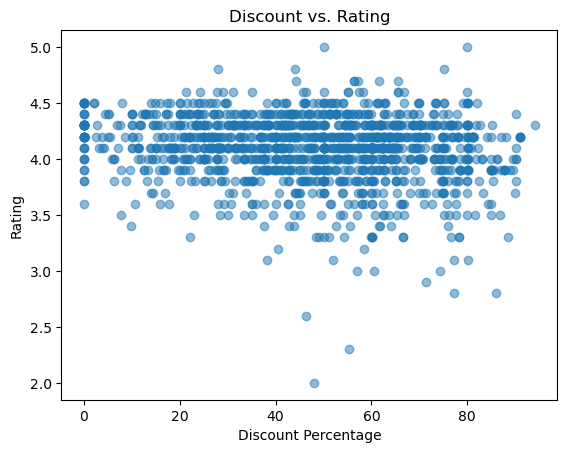

Pearson Correlation: -0.156
Spearman Correlation: -0.146


In [13]:
plt.scatter(df['discount_pct'], df['rating_clean'], alpha=0.5)
plt.xlabel('Discount Percentage')
plt.ylabel('Rating')
plt.title('Discount vs. Rating')
plt.show()

from scipy.stats import pearsonr, spearmanr

pearson_corr, _ = pearsonr(df['discount_pct'], df['rating_clean'])
spearman_corr, _ = spearmanr(df['discount_pct'], df['rating_clean'])

print(f"Pearson Correlation: {pearson_corr:.3f}")
print(f"Spearman Correlation: {spearman_corr:.3f}")


Items with high discount have a marginal decrease in rating. 

ii) Categories

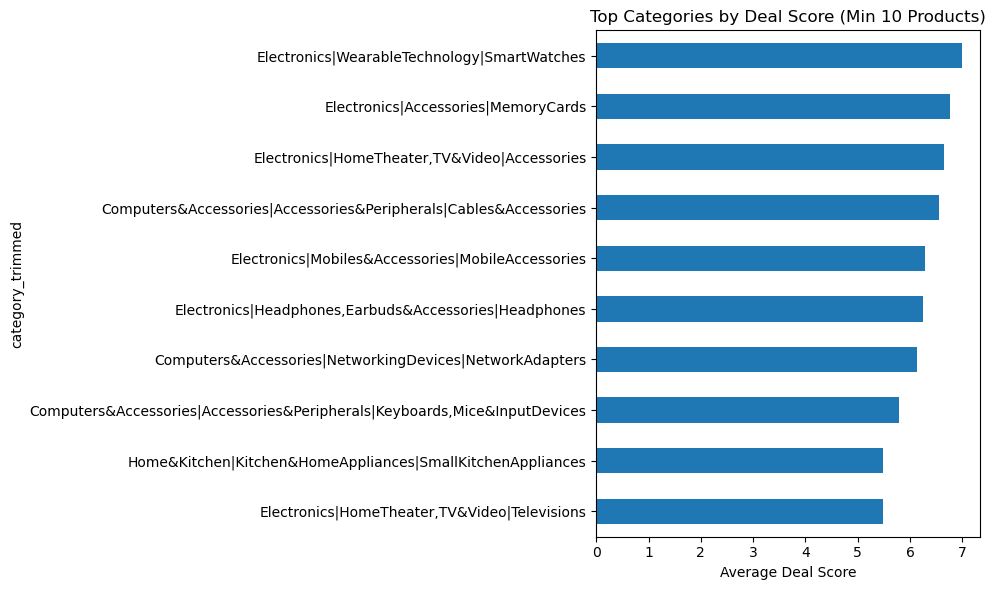

In [12]:
# SHORTEN CATEGORY
def trim_category(cat_string):
    parts = str(cat_string).split('|')
    return '|'.join(parts[:3]) if len(parts) >= 3 else cat_string
qualified['cat_trim'] = qualified['category'].apply(trim_category)
category_counts = qualified['cat_trim'].value_counts()
valid_categories = category_counts[category_counts >= 10].index
filtered = qualified[qualified['cat_trim'].isin(valid_categories)]

# Step 3: Compute average deal score by category
category_deals = (
    filtered.groupby('cat_trim')['deal_score']
    .mean()
    .sort_values(ascending=False)
)

import matplotlib.pyplot as plt

category_deals.head(10).plot(kind='barh', figsize=(10, 6))
plt.xlabel('Average Deal Score')
plt.title('Top Categories by Deal Score (Min 10 Products)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


roduct categories are represented in a hierarchical, pipe-delimited taxonomy, where each subsequent level denotes a more specific subcategory. By splitting at an earlier point, such as the third branch, we can find the top performing categories by Deal Score without being too encompassing or too specific. Smart Watches have some of the highest Deal Score, suggesting customer interest and satisfaction. 

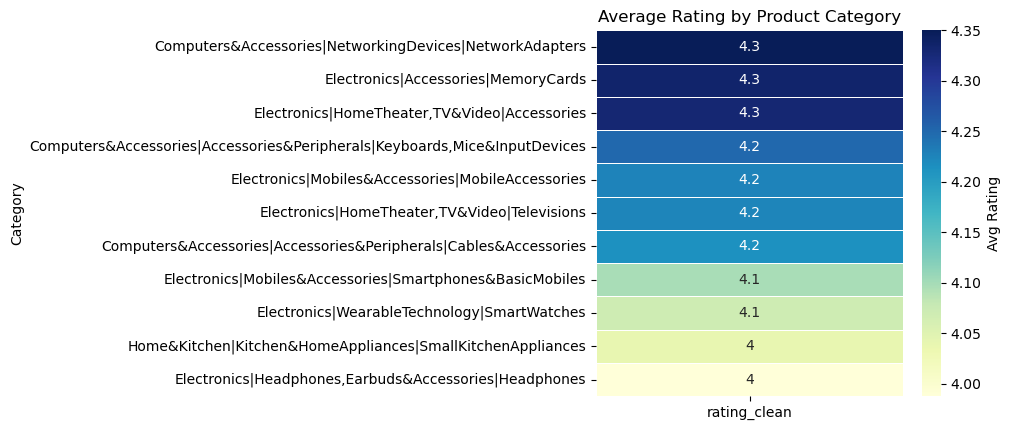

In [14]:

category_ratings = (
    filtered.groupby('cat_trim')['rating_clean']
    .mean()
    .sort_values(ascending=False)
)

# Reorder categories based on rating
ordered_categories = category_ratings.index

# Plot heatmap
plt.figure(figsize=(10, len(ordered_categories) * 0.4))
sns.heatmap(
    filtered.pivot_table(index='cat_trim', values='rating_clean', aggfunc='mean')
    .loc[ordered_categories],
    annot=True,
    cmap='YlGnBu',
    linewidths=0.5,
    cbar_kws={'label': 'Avg Rating'}
)

plt.title('Average Rating by Product Category')
plt.xlabel('')
plt.ylabel('Category')
plt.tight_layout()
plt.show()


By strict rating, Network Adapters are performing the best. 

Next, we can analyze a to identify which product categories are most price-sensitive. This way we can see where higher prices tend to lower ratings or review activity, and where premium pricing is positively associated with customer perception

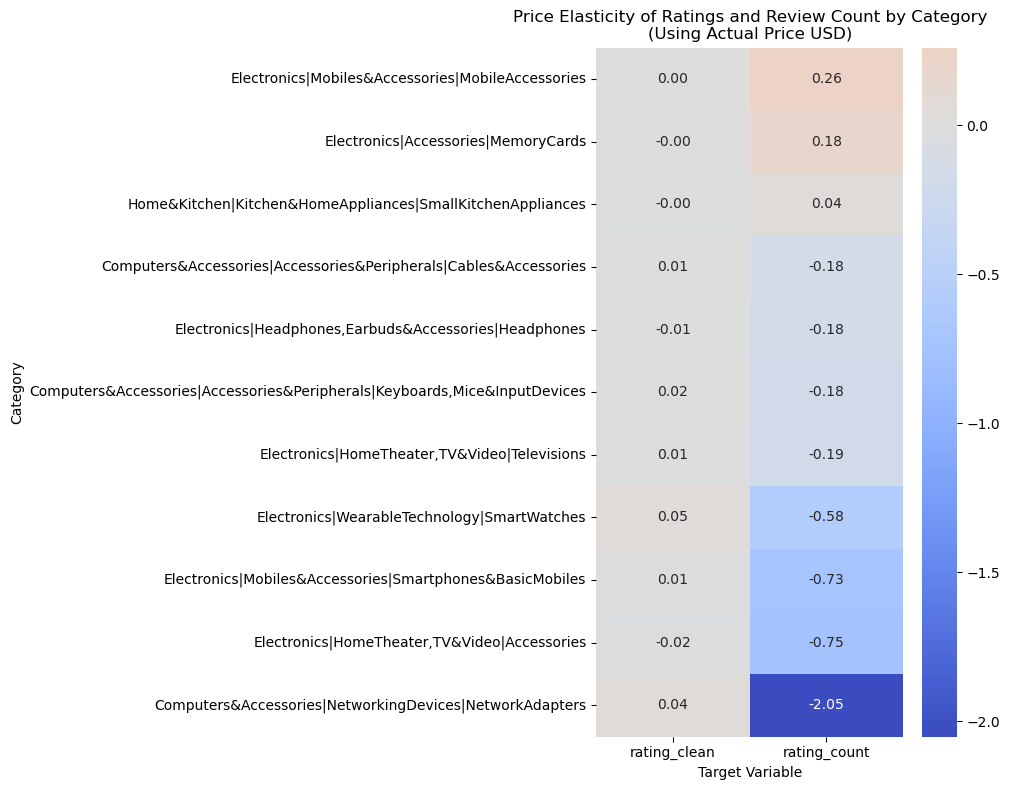

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Step 1: Prep your data
df = qualified.copy()

# Clean data
df['actual_price_usd'] = pd.to_numeric(df['actual_price_usd'], errors='coerce')
df['rating_clean'] = pd.to_numeric(df['rating_clean'], errors='coerce')
df['rating_count'] = pd.to_numeric(df['rating_count'], errors='coerce')

# Use trimmed category
df['category_trimmed'] = df['category'].apply(trim_category)

# Filter valid rows
df = df.dropna(subset=['actual_price_usd', 'rating_clean', 'rating_count', 'category_trimmed'])
df = df[df['actual_price_usd'] > 0]

# Filter for categories with enough samples
cat_counts = df['category_trimmed'].value_counts()
valid_cats = cat_counts[cat_counts >= 10].index
df = df[df['category_trimmed'].isin(valid_cats)]

# Step 2: Build elasticity estimates per category
elasticity_results = []

for cat in valid_cats:
    cat_df = df[df['category_trimmed'] == cat]
    
    # Log transform to capture % change relationships
    X = np.log(cat_df[['actual_price_usd']])
    
    for target in ['rating_clean', 'rating_count']:
        y = np.log(cat_df[target] + 1)  # +1 to avoid log(0)

        model = LinearRegression()
        model.fit(X, y)
        coef = model.coef_[0]
        
        elasticity_results.append({
            'category': cat,
            'target': target,
            'elasticity': coef
        })

# Step 3: Convert to DataFrame
elasticity_df = pd.DataFrame(elasticity_results)

# Step 4: Pivot for heatmap-style view
pivot = elasticity_df.pivot(index='category', columns='target', values='elasticity')
pivot = pivot.sort_values(by='rating_count', ascending=False)

# Step 5: Plot
plt.figure(figsize=(10, 8))
sns.heatmap(pivot, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Price Elasticity of Ratings and Review Count by Category\n(Using Actual Price USD)')
plt.xlabel('Target Variable')
plt.ylabel('Category')
plt.tight_layout()
plt.show()


As we can see, review counts are more price-sensitive. Most categories show negative elasticities, indicating that higher-priced products attract fewer reviews, likely due to lower purchase volume.

The strongest negative sensitivities appear in Network Adapters, Smartwatches, and Accessories, suggesting these categories experience the sharpest drop in engagement as prices rise. In contrast, Mobile Accessories and Memory Cards show slightly positive elasticities, implying consistent or even higher engagement at higher price points.